# Creating Cutouts of Roman Data with Astrocut

---

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Introduction

The [`astrocut`](https://astrocut.readthedocs.io/en/latest/) tool allows users to generate cutouts out of large astronomical images. In this tutorial, we demonstrate how to use `astrocut` to generate cutouts from a sumlated calibrated rate image product Level 2 (L2) created with Roman I-Sim.

## Imports

The following packages are used for these reasons:

- *asdf* - To handle ASDF input and output
- *roman_datamodels* - To read Roman WFI ASDF files
- *s3fs* - To access cloud files as though they were local
- *matplotlib* - The plotting package used for demonstrating the cutout
- *numpy* - To handle array functions
- *astrocut* - The main package import, used to generate the cutouts from the input file
- *astropy* - To manage the output FITS data file type and handle input sky coordinates

In [1]:
import warnings
from copy import deepcopy

import asdf
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import roman_datamodels as rdm
import s3fs
from astrocut import get_center_pixel, ASDFCutout
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.utils.exceptions import AstropyDeprecationWarning

# Ignore warnings from the 'astropy.wcs' module
# When creating cutouts -> WARNING: Polynomial distortion is not implemented.
warnings.filterwarnings('ignore', module='astropy.wcs')

# Ignore AstropyDeprecationWarning
# When creating cutouts -> WARNING: AstropyDeprecationWarning: The class "Fits" has been renamed to "FITS" in version 7.0.
# The old name is deprecated and may be removed in a future version. Use FITS instead. [astropy.units.format]
warnings.filterwarnings('ignore', category=AstropyDeprecationWarning)

---

## Setup

The first step of the analysis is to read the Roman WFI image data, which are stored in Advanced Scientific Data Format ([ASDF](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/introduction-to-asdf)) files. For this example, we start with a calibrated L2 simulated image created with [Roman I-Sim](https://romanisim.readthedocs.io/en/latest/). For more information about Roman's data products, check the [Roman User Documentation](https://roman-docs.stsci.edu/).

After launch, Roman data will be available through the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/). For testing purposes, some simulated data has been placed in a separate S3 bucket. In this notebook, we access a simulated Roman data file from the RRN S3 bucket using `s3fs`. For more information about how to access the S3 bucket, please see the [Data Discovery and Access](../data_discovery_and_access/data_discovery_and_access.ipynb) tutorial.

In [2]:
# We open a connection to the notebooks S3 storage area and
# select our file.
fs = s3fs.S3FileSystem(anon=True)
asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
asdf_file_uri = asdf_dir_uri + 'r0003201001001001004_0001_wfi02_f106_cal.asdf'

# Read the relevant data into memory
with fs.open(asdf_file_uri, 'rb') as f:
    with asdf.open(f) as af:
        dm = rdm.open(af)
        data = deepcopy(dm.data)  # Loads the WFI data into memory
        gwcs = deepcopy(dm.meta.wcs)  # Loads the WCS information into memory

## Examine Coordinates

### GWCS

Roman ASDF images use a [Generalized World Coordinate System (GWCS)](https://gwcs.readthedocs.io/en/latest/index.html) object to handle coordinate transformations, as opposed to the [Flexible Image Transport System (FITS)](https://fits.gsfc.nasa.gov/fits_primer.html) [WCS standard](https://fits.gsfc.nasa.gov/fits_wcs.html). GWCS is more flexible than FITS WCS, and contains a compound model of transformations from detector to world coordinates. Let's examine the sky and pixel coordinates of our image:

In [3]:
# Pring the GWCS Info:
print("=== WCS Information ===")
print(f"Input frame : {gwcs.input_frame}")
print(f"Output frame: {gwcs.output_frame}")

bb = gwcs.bounding_box
if bb is None:
    print("Bounding box : <none>")
else:
    # Iterate over intervals of bb  ModelBoundingBox
    intervals = {}
    for name, ivl in bb.intervals.items():
        intervals[name] = (ivl.lower, ivl.upper)

    # Roman WFI uses (x0, x1) = (col, row)
    x0_low, x0_high = intervals.get('x0', intervals[0])
    x1_low, x1_high = intervals.get('x1', intervals[1])

    print("\nPixel bounding box (inclusive half-pixel convention):")
    print(f"  x0 (columns) : [{x0_low:.1f}, {x0_high:.1f}]")
    print(f"  x1 (rows)    : [{x1_low:.1f}, {x1_high:.1f}]")
    print(f"  Shape        : {int(x0_high - x0_low)} × {int(x1_high - x1_low)} pixels")
    print(f"  Order        : {bb.order!r}")

# Sky footprint
footprint = gwcs.footprint()
print("\nSky footprint (RA, Dec in degrees):")
for i, (ra, dec) in enumerate(footprint):
    print(f"  Corner {i}: RA = {ra:9.5f}°, Dec = {dec:9.5f}°")

=== WCS Information ===
Input frame : detector
Output frame: world

Pixel bounding box (inclusive half-pixel convention):
  x0 (columns) : [-0.5, 4087.5]
  x1 (rows)    : [-0.5, 4087.5]
  Shape        : 4088 × 4088 pixels
  Order        : 'F'

Sky footprint (RA, Dec in degrees):
  Corner 0: RA = 270.93431°, Dec =  -0.37074°
  Corner 1: RA = 270.93424°, Dec =  -0.25044°
  Corner 2: RA = 270.80947°, Dec =  -0.25001°
  Corner 3: RA = 270.81040°, Dec =  -0.37022°


### Coordinate Analysis

We will analyze the coordintes of three points in the image.

First we will define some helper functions:

In [4]:
# Define some helper functions
def get_sep(coord1, coord2):
    """ Compute separation between two sky coordinates """
    return coord1.separation(coord2).to(u.arcsec)

def get_pix_info(xx, coord):
    """ Print some pixel coordinate info """
    print('Pixel Coord:', xx)
    ss = gwcs.pixel_to_world(*xx)
    print(f"Computed Sky Coord RA, Dec = {ss.ra.deg:.6f}°, {ss.dec.deg:.6f}°")
    print('Separation:', get_sep(coord, ss))

def print_coord_info(coord):
    """ Print some sky coordinate info """
    print(f"Input Sky Coord: RA, Dec = {coord.ra.deg:.6f}°, {coord.dec.deg:.6f}°")
    # angular distance between known and WCS-computed position
    xx = gwcs.invert(coord)
    get_pix_info(xx, coord)

Next, we will derive the coordinates for the center, the far upper-right corner, and the far lower-left corner in the image. Once derived we will compute the pixel coordinates, the computed sky coordinates, and the separation between the input and computed sky coordinates.

In [5]:
# Sky coord of central pixel
print('Center Pixel')
print('-------------------')
nrows, ncols = data.shape

# center pixel
center_row = nrows // 2
center_col = ncols // 2
center_coord = gwcs.pixel_to_world(center_col, center_row)

print(f"Center pixel: ({center_col}, {center_row})")
print_coord_info(center_coord)
print('\n')

# Sky coord at far edge (upper right)
print('Right upper corner pixel')
print('-----------------------------')
ss = gwcs.pixel_to_world(4077, 4077)
print_coord_info(ss)
print('\n')

# Sky coord at far edge (lower left)
print('Left lower corner pixe')
print('---------------------------')
ss = gwcs.pixel_to_world(2, 2)
print_coord_info(ss)
print('\n')

# Get computed pixel coordinates from world coordinates with get_center_pixel()
test_coord = SkyCoord('270.8719 -0.26437', unit='deg')  # test out different sky coordinates here!
print('Get the closest pixel location for a given set of coordinates:')
print('--------------------------------')
print(f'Sky Coord: {test_coord.ra.deg:.6f}°, {test_coord.dec.deg:.6f}°')
pc, ww = get_center_pixel(gwcs, test_coord.ra, test_coord.dec)
get_pix_info(pc, test_coord)


Center Pixel
-------------------
Center pixel: (2044, 2044)
Input Sky Coord: RA, Dec = 270.872040°, -0.310753°
Pixel Coord: [2044.0000000735474, 2043.9999998555172]
Computed Sky Coord RA, Dec = 270.872040°, -0.310753°
Separation: 1.7139e-08 arcsec


Right upper corner pixel
-----------------------------
Input Sky Coord: RA, Dec = 270.809795°, -0.250329°
Pixel Coord: [4077.001113065403, 4077.001054530964]
Computed Sky Coord RA, Dec = 270.809795°, -0.250329°
Separation: 0.00016721 arcsec


Left lower corner pixe
---------------------------
Input Sky Coord: RA, Dec = 270.934231°, -0.370664°
Pixel Coord: [2.0010593597287425, 2.0021859404735096]
Computed Sky Coord RA, Dec = 270.934231°, -0.370664°
Separation: 0.000256678 arcsec


Get the closest pixel location for a given set of coordinates:
--------------------------------
Sky Coord: 270.871900°, -0.264370°
Pixel Coord: (2042.5136762712461, 3614.2992578361936)
Computed Sky Coord RA, Dec = 270.871900°, -0.264370°
Separation: 5.51746e-05 arc

---
## Creating the ASDF Image Cutout

Here, we will create the image cutout.  First, we plot the original image, then zoom in on the expected cutout using a red square.

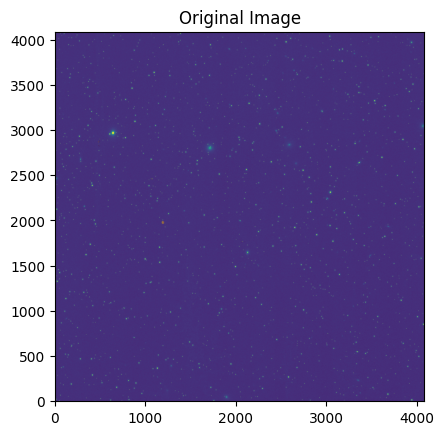

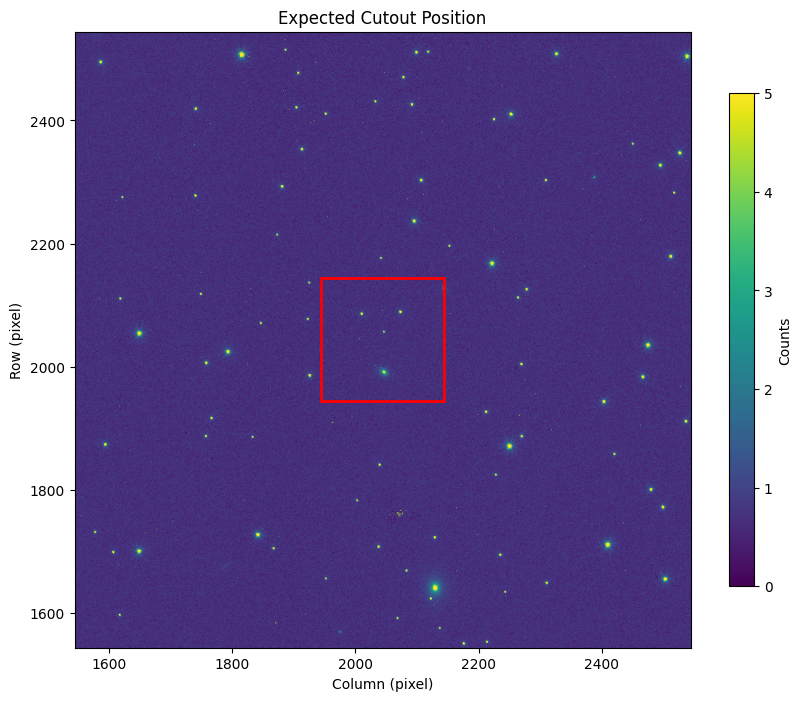

In [6]:
# Create 200×200 cutout at center
cutout_size = 200
cutout = Cutout2D(data, position=(center_col, center_row), size=cutout_size)

# Define cutout coordinates at center
coord = center_coord  # SkyCoord from gwcs.pixel_to_world()

# Plot original image
plt.title('Original Image')
plt.imshow(data, vmin=0, vmax=5, origin='lower')

# Plot the expected cutout with red square
pix, wcs_pix = get_center_pixel(gwcs, coord.ra, coord.dec)

# Plot image at expected cutout position
plt.figure(figsize=(10, 8))
plt.title('Image at expected position (Red = Sky Coord)')
plt.imshow(data, vmin=0, vmax=5, origin='lower', cmap='viridis')

# Plot cutout from sky coordinate
tmp = Cutout2D(data, position=pix, wcs=wcs_pix, size=cutout_size, mode='partial')
tmp.plot_on_original(color='red', linewidth=2)

# Zoom in around center (FIXED: xlim = columns, ylim = rows)
plt.title('Expected Cutout Position')
padding = 500
plt.xlim(center_col - padding, center_col + padding)  # X = column
plt.ylim(center_row - padding, center_row + padding)  # Y = row
plt.xlabel('Column (pixel)')
plt.ylabel('Row (pixel)')
plt.colorbar(label='Counts', shrink=0.8)
plt.show()

Now we will use `Astrocut` to creates cutouts of our data file.

To make a cutout from an ASDF file or files, we use the `ASDFCutout` class.

In [7]:
# Create the image cutout
asdf_cutout = ASDFCutout(asdf_file_uri, coord, cutout_size)

The resulting object can be used to access the cutout science data and metadata of one or a list of ASDF files. In here, `cutouts` can be a list of science data cutouts, one for each input file. For more options refer to the [Astrocut documentation](https://astrocut.readthedocs.io/en/latest/astrocut/index.html#asdf-cutouts).

In [8]:
# Check the cutout shape and position
cutout = asdf_cutout.cutouts[0]
print('Cutout Data Shape:', cutout.shape)
print('Cutout Original Position:', cutout.position_original)
print('Cutout Position:', cutout.position_cutout)

Cutout Data Shape: (200, 200)
Cutout Original Position: (2044, 2044)
Cutout Position: (99, 100)


### Inspecting the ASDF Cutout Object

Now let's inspect the ASDFCutout tree structure and HDUList object using .info()

In [9]:
cutout_asdf = asdf_cutout.asdf_cutouts[0]
cutout_asdf.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (dict)
│ ├─extensions (list) ...
│ └─entries (list) ...
└─roman (WfiImage) # Level 2 (L2) Calibrated Roman Wide Field Instrument (WFI) Rate Image.
  ├─meta (dict) ...
  ├─data (ndarray) # Science Data (DN/s) or (MJy/sr) ...
  ├─dq (ndarray) # Data Quality ...
  ├─err (ndarray) # Error (DN / s) or (MJy / sr) ...
  ├─var_poisson (ndarray) # Poisson Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─var_rnoise (ndarray) # Read Noise Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─var_flat (ndarray) # Flat Field Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─amp33 (ndarray) # Amplifier 33 Reference Pixel Data (DN) ...
  ├─border_ref_pix_left (ndarray) # Left-Edge Border Reference Pixels (DN) ...
  ├─border_ref_pix_right (ndarray) # Right-Edge Border Reference Pixels (DN) ...
  ├─border_ref_pix_top (ndarray) # Bord

In [10]:
cutout_fits = asdf_cutout.fits_cutouts[0]
cutout_fits.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   (200, 200)   float32   


#### Plot Cutout in Pixel Coordinates

Extract Science Data and WCS from ASDF Tree.

In [11]:
data_asdf = cutout_asdf['roman']['data']
gwcs_asdf = cutout_asdf['roman']['meta']['wcs']

Next, we will plot the cutout in pixel coordinates. The pixel coordinates are shown along the axes, and the cutout is a 200 x 200 pixel square.

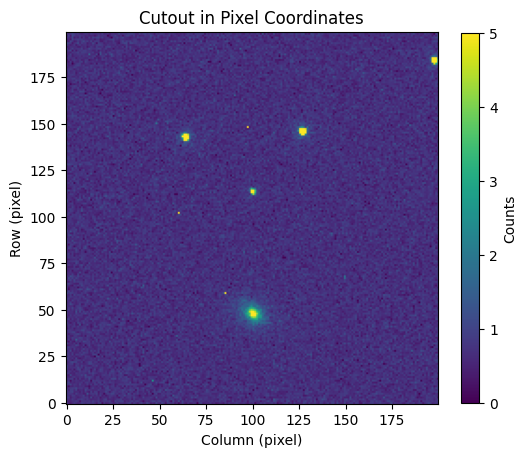

In [ ]:
def plot_cutout_pixel(img):
    """ Display the cutout using pixel coordinates """
    plt.figure(figsize=(6, 6))
    plt.imshow(img, vmin=0, vmax=5, origin="lower")
    plt.title('Cutout in Pixel Coordinates')
    plt.xlabel('Column (pixel)')
    plt.ylabel('Row (pixel)')
    plt.colorbar(label='Counts', shrink=0.8)
    plt.show()

plot_cutout_pixel(data_asdf)

#### Plot Cutout in Sky Coordinates

Now we will plot the cutout in sky coordinates using the projection defined by the WCS object.

In [ ]:
# We create a convenience function
def plot_cutout_world(img, coord, wcs):    
    """ Display the cutout using world coordinate system """
    plt.figure(figsize=(6, 6))
    plt.title('Cutout in Sky Coordinates')
    plt.xticks([])  # Disable tick marks
    plt.yticks([])
    ax = plt.subplot(projection=wcs)
    ax.imshow(img, vmin=0, vmax=5, origin='lower')

    # Add grid lines
    ax.grid(color='white', ls='solid')
    
    # Overplot the original sky coordinate in cyan
    ax.scatter_coord(coord, s=100, edgecolor='cyan', facecolor='none')
    
    # Plot central pixel in white
    center_loc = img.shape[0] // 2
    ax.scatter([center_loc], [center_loc], s=100, edgecolor='white', facecolor='none')

    # Plot sky coord of central pixel in yellow
    if hasattr(wcs, 'all_pix2world'):
        # WCS case
        ra, dec = wcs.all_pix2world(center_loc, center_loc, 0)
    else:
        # GWCS case
        ra, dec = wcs(center_loc, center_loc)
    cc = SkyCoord(ra, dec, unit='deg')
    ax.scatter_coord(cc, s=50, edgecolor='yellow', facecolor='none')
    
    plt.show()

   From                   Transform                
---------- ----------------------------------------
  detector                            CompoundModel
      v2v3                                 Identity
v2v3vacorr JWST tangent-plane linear correction. v1
  v2v3corr                                 v23tosky
     world                                     None 

SkyCoords Info:
Input Requested <SkyCoord (ICRS): (ra, dec) in deg
    (270.87203961, -0.310753)>


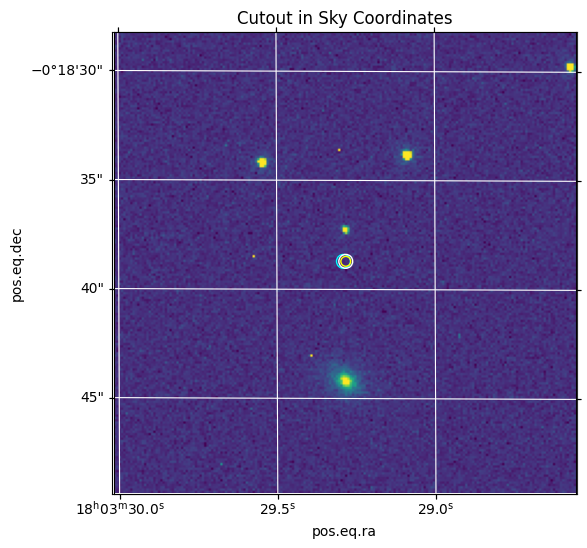

In [15]:
# Print the cutout GWCS
print(gwcs_asdf, '\n')

# Print the position of input coordinates
print("SkyCoords Info:")
print('Input Requested', coord)

# Plot the figure with WCS
header_gwcs = gwcs_asdf.to_fits_sip()
wcs = WCS(header_gwcs)
plot_cutout_world(data_asdf, coord, wcs)

#### Plot FITS Cutout in Pixel Coordinates

Now, let's inspect the FITS cutout object and display the cutout in pixel coordinates with matplotlib. The pixel coordinates are shown along the axes, and the cutout is a 200 x 200 pixel square.

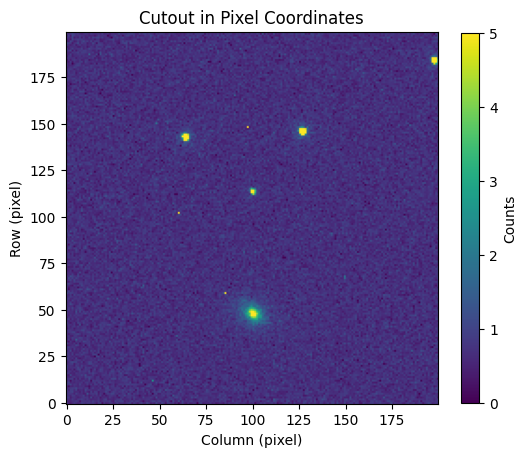

In [16]:
data_fits = cutout_fits[0].data
header = cutout_fits[0].header
wcs_fits = WCS(header)

plot_cutout_pixel(data_fits)

---

## Partial Image Cutouts

Sometimes, cutouts are made near the edge of Roman images. In these cases, part of the cutout may fall outside of the original image.

The `ASDFCutout` class takes an optional `fill_value` parameter for this circumstance. It describes the value that should be given to any pixels in the cutout that fall outside of the input image. The default value is `np.nan`.

To illustrate this, we will take a cutout from the lower right corner of the image. The cutout will be 300 pixels on each side.

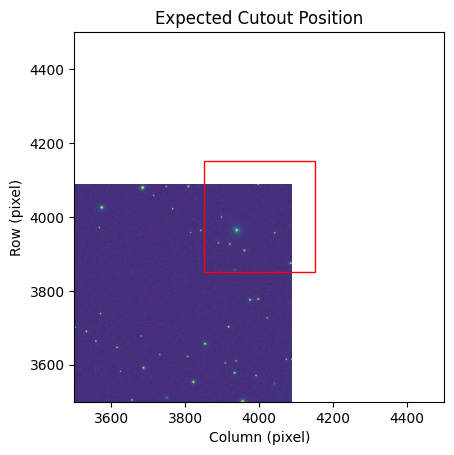

In [17]:
# We pick values for the edges that are greater
# than the Roman images
cutout_size = 300
edge_x = 4000
edge_y = 4000

# Convert to sky coordinates
edge_coord = gwcs.pixel_to_world(edge_x, edge_y)
edge_coord

# Plot original image
plt.imshow(data, vmin=0, vmax=5, origin='lower')

# Plot the expected cutout with red square
pc, ww = get_center_pixel(gwcs, edge_coord.ra, edge_coord.dec)
tmp = Cutout2D(data, position=pc, wcs=ww, size=cutout_size, mode='partial')
tmp.plot_on_original(color='red')

# More plot details
plt.title('Expected Cutout Position')
plt.xlabel('Column (pixel)')
plt.ylabel('Row (pixel)')
padding = 500
plt.xlim(edge_x - padding, edge_x + padding)
plt.ylim(edge_y - padding, edge_y + padding)
plt.show()

Notice how the top and right side of the square are outside of the image. We can assign the value of these pixels in our cutout using the `fill_value` parameter. The outside pixels with a value of 0.

In [18]:
# Create the partial image cutout with fill_value = 0
asdf_cutout_partial = ASDFCutout(asdf_file_uri, edge_coord, cutout_size, fill_value=0)

# Get Cutout2D object
cutout_partial = asdf_cutout_partial.cutouts[0]
print('Cutout Data Shape:', cutout_partial.shape)
print('Cutout Original Position:', cutout_partial.position_original)
print('Cutout Position:', cutout_partial.position_cutout)

Cutout Data Shape: (300, 300)
Cutout Original Position: (4000, 4000)
Cutout Position: (149, 149)


Let's inspect the cutout object and display it with matplotlib.

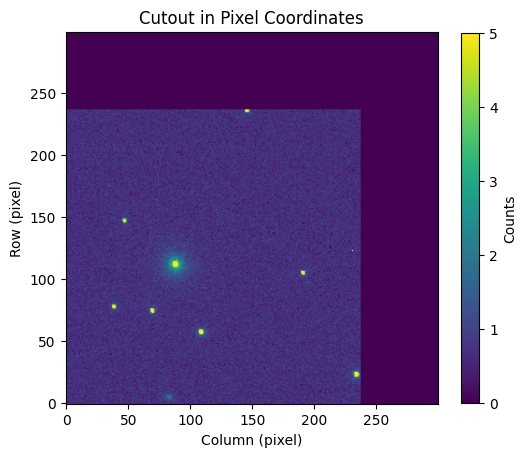

In [19]:
# Plot cutout in pixel coordinates
plot_cutout_pixel(cutout_partial.data)

Now we will plot the cutout in sky coordinates.

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP'
CUNIT : 'deg' 'deg'
CRVAL : 270.87205488452 -0.3107677732372
CRPIX : -1806.5 -1806.5
CD1_1 CD1_2  : -3.0426420203558e-05 -1.2146466368114e-07
CD2_1 CD2_2  : 1.1541852911358e-07 2.9423912122249e-05
NAXIS : 300  300 

SkyCoords Info:
Input Requested <SkyCoord (ICRS): (ra, dec) in deg
    (270.81215552, -0.25262916)>


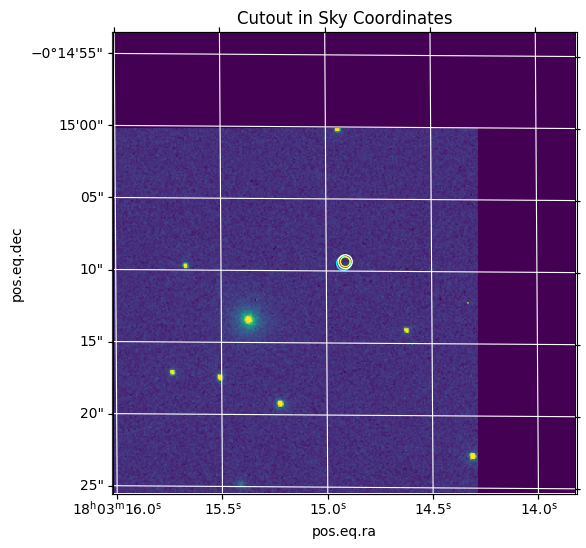

In [20]:
# Print the cutout wcs
print(cutout_partial.wcs, '\n')

# Print FITS WCS position of various sky coordinates
print("SkyCoords Info:")
print('Input Requested', edge_coord)

# Plot the figure with wcs
plot_cutout_world(cutout_partial.data, edge_coord, cutout_partial.wcs)

As expected, the pixels that fall outside of the original image have been assigned a value of 0.

---

## Additional Resources

- [Astrocut Documentation](https://astrocut.readthedocs.io)
- [Advanced Scientific Data Format Documentation](https://asdf.readthedocs.io/en/latest/)

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>